## Finding the best fitting regression model for binary subset of the data (one protein at a time)
- for a given protein, fit a regression model and optimize for the best fit
- using embeddings (efficientnet.tfkeras import EfficientNetB0) as input features

In [1]:
# Import all the libraries I need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

import pyarrow.parquet as pq

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

base_path = '/Users/reneebrecht/neue_fische/human-protein-atlas-image-classification/data/'
embed_path = '/Users/reneebrecht/neue_fische/human-protein-atlas-image-classification/data/embeddings_train/'


### Loading the image labels and image names

In [2]:
#get all of the labels
labels_training = pd.read_csv(base_path+'train.csv')

### Some setup

In [3]:
class Location_in_Target(object):
    ''' Class to get a list of name of pictures which are labeled with a specific 
        location and the same number of names of pictures which labels do not 
        contain the specific location.
        ...
        Attributes:
        ----------
        location: int 
            number which define a location in a human cell
        pictures: panda.DataFrame
            list of the names of the pictures labeled with the location and 
            same number of pictures without the label
        
        Methods:
        ----------
        save_pictures(pictures, column_name):
            Saves the list of picture names in an Attribute
        get_pictures()
            Returns the list of picture names
        determine_pictures(labels)  
            Find pictures with and without the specific label and call save method
            when list is build
    '''

    def __init__(self, location): 
        '''Parameters
           ----------
           location: int 
                number which define a location in a human cell
        '''

        self.location = location
        self.pictures = pd.DataFrame()

    def save_pictures(self, pictures, column_name):
        ''' Saves the list of pictures in the attribute pictures

            Parameters
            ----------
            pictures: panda.DataFrame
                list of the names of the pictures labeled with the location and 
                same number of pictures without the label
            column_name: str
                Description of the data saved in the DataFrame used as column names 
        '''

        self.pictures[column_name] = pictures

    def get_pictures(self):
        '''Gives back the list of picture names which are labeled or not labeled
            with the given location
        '''

        return self.pictures

    def determine_pictures(self, labels):
        ''' First the names of the pictures labeled with the given location are 
            saved in a list and the method to save it in a DataFrame column is 
            called. 
            The same number of names from pictures not labeled with the location 
            are chosen randomly. The saving function is called with it again. 

            Parameters
            ----------
            labels: DataFrame with all picture names and Targets       
        '''

        pictures = [label.Id  for index, label in labels.iterrows() 
                              if str(self.location) in label.Target]
        self.save_pictures(pictures, f'pictures_with_location_{self.location}')
        #The number of pictures labeled with the given location is needed to get the 
        #same number of pictures not labeled with the location
        number_needed_pictures= len(pictures)
        pictures = [label.Id  for index, label in labels.iterrows() 
                              if str(self.location) not in label.Target]
        self.save_pictures(np.random.choice(pictures, number_needed_pictures),
                                f'pictures_without_location_{self.location}')

# courtesy of https://www.kaggle.com/code/allunia/protein-atlas-exploration-and-baseline
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

#### Load the full set of embeddings

In [5]:
# load embeddings (saved as parquet files), convert to pandas and get strings as strings
emb = pq.read_table(embed_path).to_pandas()
for col in ['target_id', 'image_path', 'image_name']:
    emb[col] = emb[col].str.decode('utf-8')#.fillna(df[col]) 
emb

,target_id,image_path,embedding,image_name
0,7,../data/train/4b0d7acc-bbb5-11e8-b2ba-ac1f6b64...,"[-0.14782768, -0.19346946, 0.029495712, -0.114...",4b0d7acc-bbb5-11e8-b2ba-ac1f6b6435d0
1,5 0,../data/train/4b0e4648-bbc2-11e8-b2bb-ac1f6b64...,"[-0.11768038, 0.108380914, -0.07158355, -0.051...",4b0e4648-bbc2-11e8-b2bb-ac1f6b6435d0
2,23,../data/train/4b0fe352-bbbf-11e8-b2ba-ac1f6b64...,"[-0.14264518, -0.14894637, 0.015262008, -0.138...",4b0fe352-bbbf-11e8-b2ba-ac1f6b6435d0
3,2,../data/train/4b1164e4-bbaf-11e8-b2ba-ac1f6b64...,"[-0.14977421, -0.12706101, -0.17702478, -0.087...",4b1164e4-bbaf-11e8-b2ba-ac1f6b6435d0
4,25,../data/train/4b120c9e-bbb1-11e8-b2ba-ac1f6b64...,"[-0.15020615, -0.008659467, -0.14262204, -0.04...",4b120c9e-bbb1-11e8-b2ba-ac1f6b6435d0
...,...,...,...,...
31067,7,../data/train/9d04d730-bbb5-11e8-b2ba-ac1f6b64...,"[-0.095827445, -0.14014255, -0.1306586, -0.081...",9d04d730-bbb5-11e8-b2ba-ac1f6b6435d0
31068,4,../data/train/9d09c7e0-bb9c-11e8-b2b9-ac1f6b64...,"[-0.109680824, -0.07402489, -0.08704822, -0.08...",9d09c7e0-bb9c-11e8-b2b9-ac1f6b6435d0
31069,0,../data/train/9d0a7012-bbc6-11e8-b2bc-ac1f6b64...,"[-0.14760047, -0.105946906, 0.17695697, -0.130...",9d0a7012-bbc6-11e8-b2bc-ac1f6b6435d0
31070,25 0,../data/train/9d10ecec-bba0-11e8-b2b9-ac1f6b64...,"[-0.12235144, -0.12698074, -0.052961998, -0.10...",9d10ecec-bba0-11e8-b2b9-ac1f6b6435d0


#### Test the class with Mitochondria labeled with a 4
- create a balanced subset of images that have nuclear bodies or not

In [6]:
# INPUT: select the protein of interest and it's number
protein_name = 'Nuclear specles'
protein_number = 4

In [7]:
# picking out all the images/embeddings with the protein
selected_protein = Location_in_Target(location = protein_number)
selected_protein.determine_pictures(labels_training)
#Dataframe with filenames of pictures which have nuclear bodies
df_pro = selected_protein.get_pictures().pictures_with_location_4
#Dataframe with filenames of pictures which have no nuclear bodies
df_no_pro = selected_protein.get_pictures().pictures_without_location_4

In [8]:
# use join to pull out the embeddings of the nuclear bodies subset
# first get the nuclear bodies and set target = 1
emb_pro = emb.merge(df_pro.rename("image_name").to_frame(), how="right", on="image_name")
emb_pro["target_id"] = 1
# now the others, target = 0
emb_no_pro = emb.merge(df_no_pro.rename("image_name").to_frame(), how="right", on="image_name")
emb_no_pro["target_id"] = 0
# now combine them into one table and shuffle
df_emb_pro = pd.concat([emb_pro, emb_no_pro]).reset_index()
df_emb_pro = shuffle(df_emb_pro, random_state=0)

In [9]:
# put the features (embeddings) in one dataframe
df_feats = pd.DataFrame(list(map(np.ravel, df_emb_pro.embedding)))

In [10]:
# get the targets, one hot encode and put into a dataframe
# target dataframe
targets = df_emb_pro['target_id']
targets

3029    1
5306    0
4676    0
5640    0
1778    1
       ..
4931    0
3264    0
1653    1
2607    1
2732    1
Name: target_id, Length: 6440, dtype: int64

In [10]:
#sns.pairplot(pd.concat([df_feats,targets],axis=1).iloc[:,-10:], hue="target_id");

#### Notes:
- data may still need to be scaled
- also not uniformly distributed --- log?

In [11]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df_feats, targets, stratify = targets, random_state=1)

### Setup pipeline to preprocess data and train the model
- setting up "switcher class" so that we can try different models/classifiers; from https://stackoverflow.com/questions/51695322/compare-multiple-algorithms-with-sklearn-pipeline
 

!!! reduce overfitting
- try with, without quantile and scaler
- add regularization
- ...

In [12]:
from sklearn.base import BaseEstimator

class ClfSwitcher(BaseEstimator):
    def __init__(
        self, 
        estimator = KNeighborsClassifier(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

#### Compare different models (and some hyperparameters)

In [13]:
# Define fbeta score as the metric to compare the models
f_beta = 1
fbeta_scorer = make_scorer(fbeta_score, beta=f_beta)

In [14]:
pipeline = Pipeline([
    ('quant', QuantileTransformer(random_state=0)), 
    ('stscale',StandardScaler()),
    ('clf', ClfSwitcher()),
])

# set up the different models like hyperparameters
# list_of_clf = [LogisticRegression(), KNeighborsClassifier(), SVC(), DecisionTreeClassifier(random_state=42)]

parameters = [
#    {
#        'clf__estimator': [SGDClassifier()], 
#        'clf__estimator__penalty': ('l2'), # , 'elasticnet', 'l1'
#    },    
    #{
    #    'clf__estimator': [DecisionTreeClassifier(random_state=42)], 
    #},    
    {
        # 'clf__estimator': [KNeighborsClassifier()], #n_neighbors=3, p=1
        # 'clf__estimator__p': [1],
        # 'clf__estimator__n_neighbors': [3],
    },
#    {
#        'clf__estimator': [LogisticRegression()], 
#        'clf__estimator__penalty': ('l2'),
#    },
    # {
    #     'clf__estimator': [LinearSVC()], 
    #     'clf__estimator__penalty': ['l2'],
    #     'clf__estimator__loss': ['hinge'], #,'squared_hinge'], # , 
    #     'clf__estimator__C': [1e-3], #, 1e-2], # 1e-4, 1
    # #    'clf__estimator__dual': ['False']
    # },
    {
        'clf__estimator': [SVC()], 
        'clf__estimator__kernel': ['rbf'], #, 'sigmoid'], #'linear', ,'poly'
        'clf__estimator__C': [0.1, 0.5, 1], #, 1], # 0.1, 1, 
        'clf__estimator__gamma': [0.1, 0.5, 1, 2] #, 'auto', 'scale']
    },
    # { just gives nan, can't handle negative data
    #     'clf__estimator': [MultinomialNB()], 
    # },
]

gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, return_train_score=True, verbose=3,
                    scoring=fbeta_scorer)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV 3/5] END ..............., score=(train=0.755, test=0.594) total time= 1.8min
[CV 1/5] END ..............., score=(train=0.766, test=0.589) total time= 1.8min
[CV 2/5] END ..............., score=(train=0.762, test=0.626) total time= 1.8min
[CV 5/5] END ..............., score=(train=0.737, test=0.633) total time= 1.8min
[CV 4/5] END ..............., score=(train=0.757, test=0.618) total time= 1.8min
[CV 2/5] END clf__estimator=SVC(), clf__estimator__C=0.1, clf__estimator__gamma=0.5, clf__estimator__kernel=rbf;, score=(train=0.000, test=0.000) total time= 2.6min
[CV 1/5] END clf__estimator=SVC(), clf__estimator__C=0.1, clf__estimator__gamma=0.5, clf__estimator__kernel=rbf;, score=(train=0.673, test=0.642) total time= 2.6min
[CV 4/5] END clf__estimator=SVC(), clf__estimator__C=0.1, clf__estimator__gamma=0.1, clf__estimator__kernel=rbf;, score=(train=0.668, test=0.663) total time= 2.6min
[CV 5/5] END clf__estimator=SVC(), clf_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('quant',
                                        QuantileTransformer(random_state=0)),
                                       ('stscale', StandardScaler()),
                                       ('clf', ClfSwitcher())]),
             n_jobs=12,
             param_grid=[{},
                         {'clf__estimator': [SVC(C=1, gamma=0.1)],
                          'clf__estimator__C': [0.1, 0.5, 1],
                          'clf__estimator__gamma': [0.1, 0.5, 1, 2],
                          'clf__estimator__kernel': ['rbf']}],
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=1),
             verbose=3)

#### Notes:
- check the output of the QuantileTransformer, does it make distributions uniform?
- need to deal with overfitting
- 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,param_clf__estimator__C,param_clf__estimator__gamma,param_clf__estimator__kernel,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,104.975348,0.211123,2.485993,0.073271,NaN,NaN,NaN,NaN,{},0.589229,...,0.611911,0.017487,5,0.765562,0.762369,0.755128,0.757421,0.736677,0.755431,0.010065
1,146.918468,0.425527,11.035081,0.126438,"SVC(C=1, gamma=0.1)",0.1,0.1,rbf,"{'clf__estimator': SVC(C=1, gamma=0.1), 'clf__...",0.642305,...,0.391788,0.319960,10,0.672621,0.000000,0.669880,0.667586,0.000000,0.402017,0.328250
2,154.305952,6.757734,10.621546,0.311417,"SVC(C=1, gamma=0.1)",0.1,0.5,rbf,"{'clf__estimator': SVC(C=1, gamma=0.1), 'clf__...",0.642305,...,0.391788,0.319960,10,0.672621,0.000000,0.669880,0.667586,0.000000,0.402017,0.328250
3,161.599556,1.649412,11.252980,0.830522,"SVC(C=1, gamma=0.1)",0.1,1,rbf,"{'clf__estimator': SVC(C=1, gamma=0.1), 'clf__...",0.642305,...,0.391788,0.319960,10,0.672621,0.000000,0.669880,0.667586,0.000000,0.402017,0.328250
4,163.691796,1.334987,11.356697,0.625887,"SVC(C=1, gamma=0.1)",0.1,2,rbf,"{'clf__estimator': SVC(C=1, gamma=0.1), 'clf__...",0.642305,...,0.391788,0.319960,10,0.672621,0.000000,0.669880,0.667586,0.000000,0.402017,0.328250
5,166.024447,1.971238,10.708721,1.242571,"SVC(C=1, gamma=0.1)",0.5,0.1,rbf,"{'clf__estimator': SVC(C=1, gamma=0.1), 'clf__...",0.643110,...,0.393927,0.318426,6,0.692008,0.999219,0.688385,0.686901,0.998946,0.813092,0.151870
6,161.522067,0.354154,12.938526,0.084779,"SVC(C=1, gamma=0.1)",0.5,0.5,rbf,"{'clf__estimator': SVC(C=1, gamma=0.1), 'clf__...",0.643209,...,0.392958,0.319266,9,0.690409,0.999740,0.686662,0.685188,0.999473,0.812294,0.152949
7,170.114493,4.073289,11.593168,0.574815,"SVC(C=1, gamma=0.1)",0.5,1,rbf,"{'clf__estimator': SVC(C=1, gamma=0.1), 'clf__...",0.643209,...,0.393144,0.319424,7,0.689922,0.999740,0.686420,0.685188,0.999737,0.812201,0.153131
8,168.338088,2.010931,12.038815,0.507199,"SVC(C=1, gamma=0.1)",0.5,2,rbf,"{'clf__estimator': SVC(C=1, gamma=0.1), 'clf__...",0.643209,...,0.393144,0.319424,7,0.689679,1.000000,0.685936,0.684462,1.000000,0.812015,0.153498
9,177.237672,10.169354,12.249547,0.544402,"SVC(C=1, gamma=0.1)",1,0.1,rbf,"{'clf__estimator': SVC(C=1, gamma=0.1), 'clf__...",0.659898,...,0.685724,0.019007,1,0.999745,0.999479,0.999229,0.999483,0.999473,0.999482,0.000163


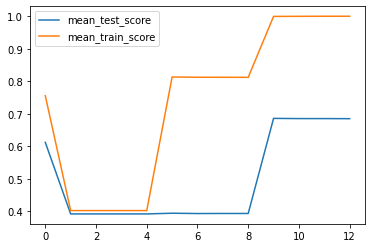

In [15]:
df_grid = pd.DataFrame(gscv.cv_results_)
df_grid.plot(y=['mean_test_score', 'mean_train_score'])
df_grid

#### Notes:
- comparing SVC and and linearSVC with regularization
    - SVC regularization with gamma and C now working, and results are better than linearSVC
    - best fits (ie not overfitting, train vs test score <3% difference) are with C=0.1, 0.5 and gamma = 0.5, 1, 2
    - GridsearchCV gives best result ast C=1 and gamma = 0.5 but this is overfitting by a wide margin (ie it's the best test score, but test score is 30% less than train score)
- tried a few more options with SVC and found best scores for:
    - C = 0.01, 0.1, gamma = 0.01, 0.05, 0.1, 1, 2, 5 
    

<!-- Old notes:
- best result was 0.6832 with: {'clf__estimator': SVC(C=10), 'clf__estimator__C': 10, 'clf__estimator__kernel': 'rbf'}
    - but this is overfitting a lot (0.99 with training and < 0.68 for test)
    - and regularization isn't an option
- in order to use regularization need to use LinearSVC, which does not overfit as much, but slightly lower score 0.652
    - {'clf__estimator': LinearSVC(C=0.01, loss='hinge'), 'clf__estimator__C': 0.01, 'clf__estimator__loss': 'hinge', 'clf__estimator__penalty': 'l2'} -->

### Set up model chosen as best with C = 0.1

In [16]:
pipeline = Pipeline([
    ('quant', QuantileTransformer(random_state=0)), 
    ('stscale',StandardScaler()),
    ('svc', SVC(kernel='rbf', C=0.1)),
])

selected_model = pipeline.fit(X_train, y_train)


##### !!! Note: 
- with C=0.1, gamma=1, model never predicts 0, always guesses 1 when run on training and test below. 
- Not setting gamma works, and is better than using all defaults, ie not setting C; (doesn't overfit as much). 

### !! how can this be? how to avoid this?

### Run the best model on the training data

Best model on train data
fbeta score: 0.6758
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.51      0.58      2415
           1       0.61      0.76      0.68      2415

    accuracy                           0.63      4830
   macro avg       0.64      0.63      0.63      4830
weighted avg       0.64      0.63      0.63      4830

------------------------------------------------------------


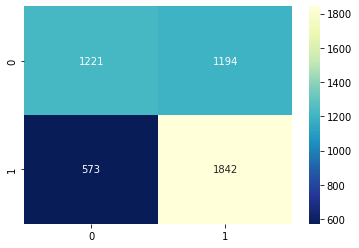

In [17]:
# Plot confusion matrix and classification report for best model
y_in = y_train
x_in = X_train
y_pred = selected_model.predict(x_in)

print("Best model on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_in, y_pred, beta=f_beta).round(4))
print("---"*20)
print(classification_report(y_in, y_pred))
print("---"*20)

cm = confusion_matrix(y_in, y_pred)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

### Set up model chosen as best with C = 1

In [19]:
pipeline = Pipeline([
    ('quant', QuantileTransformer(random_state=0)), 
    ('stscale',StandardScaler()),
    ('svc', SVC(kernel='rbf', C=1)),
])

selected_model = pipeline.fit(X_train, y_train)

Best model on train data
fbeta score: 0.8777
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      2415
           1       0.89      0.86      0.88      2415

    accuracy                           0.88      4830
   macro avg       0.88      0.88      0.88      4830
weighted avg       0.88      0.88      0.88      4830

------------------------------------------------------------


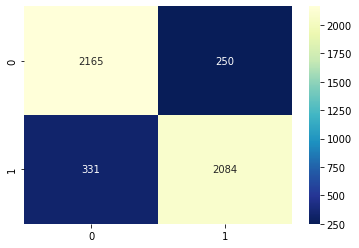

In [20]:
# Plot confusion matrix and classification report for best model
y_in = y_train
x_in = X_train
y_pred = selected_model.predict(x_in)

print("Best model on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_in, y_pred, beta=f_beta).round(4))
print("---"*20)
print(classification_report(y_in, y_pred))
print("---"*20)

cm = confusion_matrix(y_in, y_pred)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

### y_test is vertical y_pred is horizontal 

In [22]:
y_pred = model.predict(X_test)

# Plotting the confusing matrix
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

accuracy_score(y_test, y_pred.round()).round(2)
f1_score(y_test, y_pred.round()).round(2)

NameError: name 'model' is not defined

In [18]:
pipeline = Pipeline([
    ('quant', QuantileTransformer(random_state=0)), 
    ('stscale',StandardScaler()),
    ('svc', SVC(kernel='rbf', C=1)),
])

selected_model = pipeline.fit(X_train, y_train)

In [ ]:
# Plot confusion matrix and classification report for best model
y_in = y_train
x_in = X_train
y_pred = selected_model.predict(x_in)

print("Best model on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_in, y_pred, beta=f_beta).round(4))
print("---"*20)
print(classification_report(y_in, y_pred))
print("---"*20)

cm = confusion_matrix(y_in, y_pred)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

### Predict with test data

Best model on train data
fbeta score: 0.6186
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.49      0.56       772
           1       0.56      0.69      0.62       711

    accuracy                           0.59      1483
   macro avg       0.60      0.59      0.59      1483
weighted avg       0.60      0.59      0.59      1483

------------------------------------------------------------


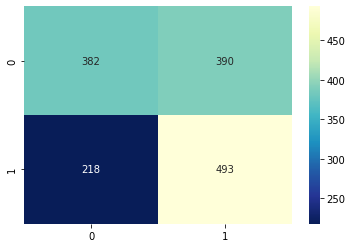

In [19]:
# Plot confusion matrix and classification report for best model
y_in = y_test
x_in = X_test
y_pred = selected_model.predict(x_in)

print("Best model on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_in, y_pred, beta=f_beta).round(4))
print("---"*20)
print(classification_report(y_in, y_pred))
print("---"*20)

cm = confusion_matrix(y_in, y_pred)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

### Initial pipeline setup for a KNN model, using defaults

In [13]:
knn_pipe = make_pipeline(QuantileTransformer(random_state=0), StandardScaler(), 
                     KNeighborsClassifier(n_neighbors=5, metric='euclidean'))
knn_pipe.fit(X_train, y_train)  # apply scaling on training data


Pipeline(steps=[('quantiletransformer', QuantileTransformer(random_state=0)),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean'))])

### Predict with train data

KNN on train data
fbeta score: 0.758
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.69      0.72      2193
           1       0.72      0.80      0.76      2254

    accuracy                           0.74      4447
   macro avg       0.74      0.74      0.74      4447
weighted avg       0.74      0.74      0.74      4447

------------------------------------------------------------


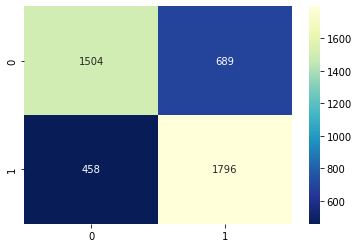

In [15]:
# Predict on test set
y_train_pred_knn = knn_pipe.predict(X_train)
f_beta = 1
print("KNN on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_train, y_train_pred_knn, beta=f_beta).round(4))
print("---"*20)
print(classification_report(y_train, y_train_pred_knn))
print("---"*20)


cm = confusion_matrix(y_train, y_train_pred_knn)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

### Predict with test data

KNN on test data
fbeta score: 0.6086
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.51      0.57       772
           1       0.56      0.67      0.61       711

    accuracy                           0.59      1483
   macro avg       0.59      0.59      0.59      1483
weighted avg       0.59      0.59      0.59      1483

------------------------------------------------------------


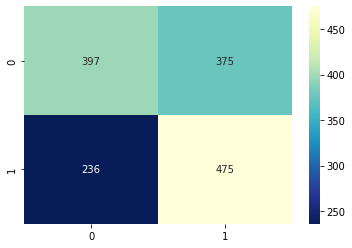

In [16]:
# Predict on test set
y_test_pred_knn = knn_pipe.predict(X_test)

print("KNN on test data")
print("==="*20)
print("fbeta score:", fbeta_score(y_test, y_test_pred_knn, beta=f_beta).round(4))
print("---"*20)
print(classification_report(y_test, y_test_pred_knn))
print("---"*20)


cm = confusion_matrix(y_test, y_test_pred_knn)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

### Initial pipeline setup for a GradientBoostingClassifier model, using defaults

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
xgb_pipe = Pipeline([
    ('quant', QuantileTransformer(random_state=0)), 
    ('stscale',StandardScaler()),
    ('xgb', GradientBoostingClassifier(n_estimators=1000, learning_rate=0.5,  max_depth=1, random_state=0))
    #('xgb', xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric=fbeta_scorer)),
])
# xgb_pipe = make_pipeline(QuantileTransformer(random_state=0), StandardScaler(), 
#                          xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric=fbeta_scorer)
#                         )
xgb_pipe.fit(X_train, y_train)  # apply scaling on training data


Pipeline(steps=[('quant', QuantileTransformer(random_state=0)),
                ('stscale', StandardScaler()),
                ('xgb',
                 GradientBoostingClassifier(learning_rate=0.5, max_depth=1,
                                            n_estimators=1000,
                                            random_state=0))])

### Predict with train data

XGBoost on train data
fbeta score: 0.9718
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2193
           1       0.97      0.98      0.97      2254

    accuracy                           0.97      4447
   macro avg       0.97      0.97      0.97      4447
weighted avg       0.97      0.97      0.97      4447

------------------------------------------------------------


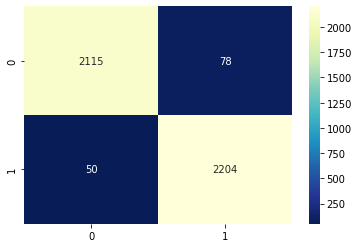

In [39]:
# Predict on test set
y_train_pred_knn = xgb_pipe.predict(X_train)
f_beta = 1
print("XGBoost on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_train, y_train_pred_knn, beta=f_beta).round(4))
print("---"*20)
print(classification_report(y_train, y_train_pred_knn))
print("---"*20)


cm = confusion_matrix(y_train, y_train_pred_knn)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

### Predict with test data

XGBoost on test data
fbeta score: 0.6473
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.63      0.65       772
           1       0.62      0.67      0.65       711

    accuracy                           0.65      1483
   macro avg       0.65      0.65      0.65      1483
weighted avg       0.65      0.65      0.65      1483

------------------------------------------------------------


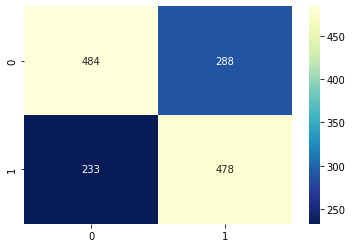

In [40]:
# Predict on test set
y_test_pred_knn = xgb_pipe.predict(X_test)

print("XGBoost on test data")
print("==="*20)
print("fbeta score:", fbeta_score(y_test, y_test_pred_knn, beta=f_beta).round(4))
print("---"*20)
print(classification_report(y_test, y_test_pred_knn))
print("---"*20)


cm = confusion_matrix(y_test, y_test_pred_knn)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

### Initial pipeline setup for a XGBoost model, using defaults
- xgboost overfits (all 1s)
- need to run hyperparameter search

In [41]:
xgb_pipe = Pipeline([
    ('quant', QuantileTransformer(random_state=0)), 
    ('stscale',StandardScaler()),
    ('xgb', xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric=fbeta_scorer)),
])
# xgb_pipe = make_pipeline(QuantileTransformer(random_state=0), StandardScaler(), 
#                          xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric=fbeta_scorer)
#                         )
xgb_pipe.fit(X_train, y_train)  # apply scaling on training data


Pipeline(steps=[('quant', QuantileTransformer(random_state=0)),
                ('stscale', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False,
                               eval_metric=make_scorer(fbeta_score, beta=1),
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=42, reg_alpha=0,
                               reg_lambda=1, ...))])

### Predict with train data

XGBoost on train data
fbeta score: 1.0
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2193
           1       1.00      1.00      1.00      2254

    accuracy                           1.00      4447
   macro avg       1.00      1.00      1.00      4447
weighted avg       1.00      1.00      1.00      4447

------------------------------------------------------------


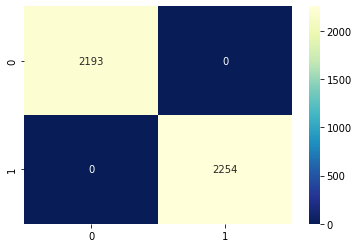

In [42]:
# Predict on test set
y_train_pred_knn = xgb_pipe.predict(X_train)
f_beta = 1
print("XGBoost on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_train, y_train_pred_knn, beta=f_beta).round(4))
print("---"*20)
print(classification_report(y_train, y_train_pred_knn))
print("---"*20)


cm = confusion_matrix(y_train, y_train_pred_knn)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

### Predict with test data

XGBoost on test data
fbeta score: 0.652
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.61      0.65       772
           1       0.62      0.69      0.65       711

    accuracy                           0.65      1483
   macro avg       0.65      0.65      0.65      1483
weighted avg       0.65      0.65      0.65      1483

------------------------------------------------------------


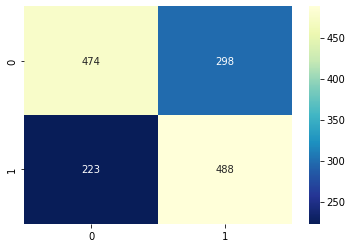

In [43]:
# Predict on test set
y_test_pred_knn = xgb_pipe.predict(X_test)

print("XGBoost on test data")
print("==="*20)
print("fbeta score:", fbeta_score(y_test, y_test_pred_knn, beta=f_beta).round(4))
print("---"*20)
print(classification_report(y_test, y_test_pred_knn))
print("---"*20)


cm = confusion_matrix(y_test, y_test_pred_knn)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");